<a href="https://colab.research.google.com/github/LimYooyeol/AI-models/blob/main/NLP/classification/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libary

In [1]:
import os
from google.colab import drive

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import urllib.request
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 데이터 로드

In [4]:
## -- 최초 로딩 방법 --
# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/pytorch-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/IMDB%20Dataset.csv", filename="IMDB Dataset.csv")
# df = pd.read_csv('IMDB Dataset.csv')
# df

In [5]:
from ast import literal_eval
df = pd.read_csv('drive/MyDrive/AI-models/data/imbd_tokenized.csv')
df['tokenized'] = df['tokenized'].apply(literal_eval)

# 데이터 전처리(인코딩)

## 모드 설정

In [6]:
mode = 'real'
#mode = 'debug'

## 라벨 변경 (text -> int), 토큰화(by spacy)

In [7]:
# -- 라벨 변경 및 토큰화 방법 --
# -- 최초 실행 후 저장된 파일 이용 --

# import spacy

# df['sentiment'] = np.where(df['sentiment'] == 'positive', 1, 0)

# nlp = spacy.load("en_core_web_sm", disable = ['ner', 'parser'])

# def tokenize(text):
#   doc = nlp(text)
#   return [token.text for token in doc]

# df['tokenized'] = df['review'].apply(tokenize)

# df.head(5)

# df.to_csv('drive/MyDrive/AI-modles/data/imbd_tokenized.csv')

## Split (vocab 학습 시 leakage 예방)

In [8]:
temp_df = []
if mode == 'debug' :
  temp_df = df[:1000] # -> 로직 검증 시 적은 데이터 사용 시
elif mode == 'real':
  temp_df = df[:20000]
X_train, X_test, y_train, y_test = train_test_split(temp_df[['tokenized']], temp_df[['sentiment']], random_state = 0, test_size = 0.2)
X_train

,tokenized
17815,"[I, do, n't, see, why, all, the, people, are, ..."
18370,"[The, Shining, is, a, weird, example, of, adap..."
1379,"[The, poet, Carne, disappears, (, didn´t, he, ..."
14763,"[Let, 's, face, it, :, the, final, season, (, ..."
7346,"[I, saw, this, stage, show, when, it, was, bro..."
...,...
13123,"[Let, me, tell, you, something, about, this, m..."
19648,"[Intrigued, by, the, synopsis, (, every, gay, ..."
9845,"[I, try, to, watch, it, everyday, most, of, th..."
10799,"[I, loved, this, movie, from, beginning, to, e..."


## Vocab 생성

In [9]:
from collections import Counter

# Counter 이용해서,
# 학습 데이터에 등장하는 단어 카운트(dict)
# ex) 'the' : 2004

word_list = []
for sent in X_train['tokenized']:
  for word in sent :
    word_list.append(word)

word_counts = Counter(word_list)

In [10]:
# vocabulary 생성

vocab = sorted(word_counts, key = word_counts.get, reverse=True)

threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 98552
등장 빈도가 2번 이하인 희귀 단어의 수: 59307
단어 집합에서 희귀 단어의 비율: 60.17838298563195
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.6672484331759159


In [11]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
if (mode == 'real') or ((rare_freq / total_freq)*100 < 20.0) :
  vocab_size = total_cnt - rare_cnt
  vocab = vocab[:vocab_size]
  print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 39245


## 정수 인코딩

In [12]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)

def integer_encoding(tokenized_text, word_to_index):
  encoded = []

  for word in tokenized_text:
    try:
      encoded.append(word_to_index[word])
    except KeyError:
      encoded.append(word_to_index['<UNK>'])

  return encoded

X_train['encoded'] = X_train['tokenized'].apply(lambda x : integer_encoding(x, word_to_index))
X_test['encoded'] = X_test['tokenized'].apply(lambda x : integer_encoding(x, word_to_index))

## 패딩

(array([8.470e+03, 4.816e+03, 1.545e+03, 6.400e+02, 3.320e+02, 1.760e+02,
        1.300e+01, 2.000e+00, 3.000e+00, 3.000e+00]),
 array([  11. ,  209.5,  408. ,  606.5,  805. , 1003.5, 1202. , 1400.5,
        1599. , 1797.5, 1996. ]),
 <BarContainer object of 10 artists>)

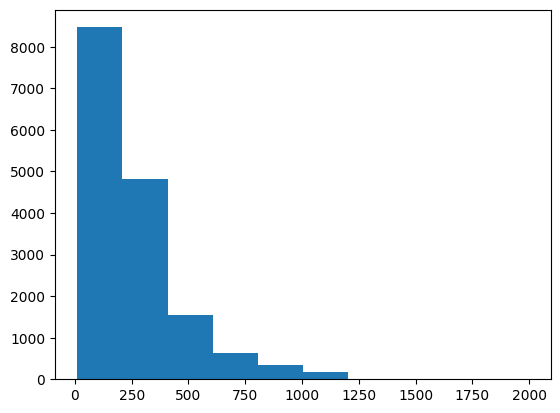

In [13]:
import matplotlib.pyplot as plt

plt.hist(X_train['encoded'].apply(lambda x : len(x)))

In [14]:
sentence_length = 600

# post padding
# prev가 좋다는 듯
def prev_padding(sentence, max_len) :
  padded = np.zeros(max_len, dtype = np.int32)

  if len(sentence) > max_len :
    padded = sentence[:max_len]
  else :
    padded[max_len - len(sentence):] = sentence

  # post padding
  # if len(sentence) != 0 :
  #   padded[:len(sentence)] = sentence[:max_len]

  return padded


X_train['encoded_padding'] = X_train['encoded'].apply(lambda x : prev_padding(x, sentence_length))
X_test['encoded_padding'] = X_test['encoded'].apply(lambda x : prev_padding(x, sentence_length))

# 모델링

## 모델 정의

In [15]:
class TextRNNClassifier(nn.Module) :

  # vocab_size :
  # embedding_dim :
  # hidden_dim :
  # output_dim :

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim) :
    super(TextRNNClassifier, self).__init__()

    # Vocab Size X E
    # Embedding[i] : i-th 단어에 대한 임베딩 벡터 (shape: 1 X E)
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # input_size: 단어 벡터 길이 (E)
    # hidden_size: RNN 출력 차원 (H)
    # --> input X W = (N X L x E) X (E x H) --> N X L X H,
    # 최종 output: L X N X H
    self.rnn = nn.RNN(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = 2, batch_first = True)

    self.ff = nn.Linear(hidden_dim, output_dim)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, text) :
    # text: N X L

    embedded = self.embedding(text)
    # N X L X E

    output, hn = self.rnn(embedded) # * batch_first = true
    # output  -> N X L X H
    # hn      -> num_layers X N X H

    # ff: H X O
    # output: N X O
    # return self.softmax(self.ff(hn[-1]))

    result = self.ff(hn[-1])

    return result, self.softmax(result)


## 데이터, 데이터로더

In [16]:
from torch.utils.data import Dataset, DataLoader

class IMDBLoader(Dataset) :

  def __init__(self, X, y) :
    self.X = torch.tensor(np.array(X.values.tolist())).to(torch.int64).to(device)
    self.y = torch.tensor(np.array(y.values.tolist())).to(torch.int64).to(device)

  def __len__(self) :
    return len(self.X)

  def __getitem__(self, idx) :
    return self.X[idx], self.y[idx]

## 정확도 평가 함수

In [17]:
# 평가 함수
def test_accuracy(model, dataset) :
  model.to(device)
  model.eval()

  correct = 0

  for i in range(dataset.__len__()) :
    X, y = dataset.__getitem__(i)

    pred = model(X)

    if torch.argmax(pred[1]) == y :
      correct = correct + 1

  return correct / dataset.__len__()


## 학습

In [38]:
def train(model, optimizer, train_dataloader, val_dataset, epochs = 10, accuracy = [], log = None, verbose = False) :
  model = model.to(device)

  for e in range(epochs) :
    cur_acc = test_accuracy(model, val_dataset)
    print('epoch :', e, '/ test accuracy :', test_accuracy(model, val_dataset))
    accuracy.append(cur_acc)

    model.train()
    for i, (x, y) in enumerate(train_dataloader) :

      pred = model(x)[0]

      loss_func = nn.CrossEntropyLoss()
      loss = loss_func(pred.to(torch.float32), y.squeeze(dim = -1))

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if verbose :
        print(loss.item())
      log.append(loss.item())
    print(log[-1])

  return accuracy, log

In [39]:
import torch.optim as optim

classifier = TextRNNClassifier(len(vocab) + 2, 100, 128, 2)

In [40]:
train_dataset = IMDBLoader(X_train['encoded_padding'], y_train)
test_dataset = IMDBLoader(X_test['encoded_padding'], y_test)

# temp_data_size = 1000
# train_dataset = IMDBLoader(X_train['encoded_padding'][:temp_data_size], y_train[:temp_data_size]) # 학습 테스트용
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

In [41]:
classifier.to(device)
# optimizer = optim.Adagrad(classifier.parameters(), lr = 0.001)
optimizer = optim.Adam(classifier.parameters(), lr = 0.001)
log = []
accuracy = []
result = train(classifier, optimizer, train_dataloader, test_dataset, 20, accuracy, log, False)

epoch : 0 / test accuracy : 0.50025
0.6882162690162659
epoch : 1 / test accuracy : 0.57225
0.6276651620864868
epoch : 2 / test accuracy : 0.65125
0.4869828522205353
epoch : 3 / test accuracy : 0.697
0.4954491853713989
epoch : 4 / test accuracy : 0.6985
0.6802685856819153
epoch : 5 / test accuracy : 0.6265
0.6800821423530579
epoch : 6 / test accuracy : 0.5435
0.6304345726966858
epoch : 7 / test accuracy : 0.59825
0.6350432634353638
epoch : 8 / test accuracy : 0.631
0.6062156558036804
epoch : 9 / test accuracy : 0.67375
0.3838171362876892
epoch : 10 / test accuracy : 0.69825
0.6124094128608704
epoch : 11 / test accuracy : 0.6775
0.48412618041038513
epoch : 12 / test accuracy : 0.70125
0.5739521980285645
epoch : 13 / test accuracy : 0.6685
0.3981030583381653
epoch : 14 / test accuracy : 0.71325
0.34489476680755615
epoch : 15 / test accuracy : 0.72475
0.5295495390892029
epoch : 16 / test accuracy : 0.65
0.36685559153556824
epoch : 17 / test accuracy : 0.693
0.29996612668037415
epoch : 18 /

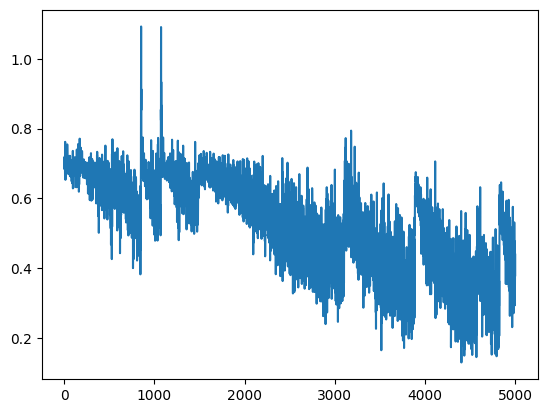

In [42]:
plt.plot(result[1])

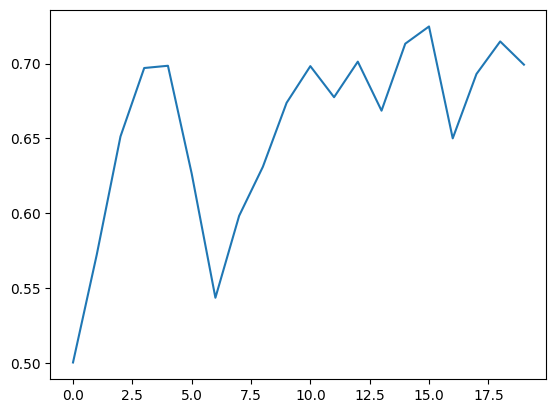

In [43]:
plt.plot(result[0])